### 0. Preparation
Before any analyses we will prepare the dataset for the subsequent modelling.

1. Load the Auto dataset into R or Python.
2. Drop all variables except the (potential) predictors ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year'] and the target variable 'mpg'.
3. Split the dataset into a training set (80%) and a validation set (20%). It is probably a good idea to set a random seed and shuffle the dataset prior to this.

In [1]:
import numpy as np
import pandas as pd

np.random.seed(42)

predictors = ['cylinders', 'displacement', 'horsepower', 'weight', 
              'acceleration', 'year']
target = 'mpg'

df = pd.read_csv('https://www.statlearning.com/s/Auto.csv',
                 usecols=predictors + [target], 
                 na_values=['?'], dtype=float)
df = df.sample(frac=1.0)

train = df[:int(len(df) * 0.8)]
validation = df[int(len(df) * 0.8):]

print(f'Using {len(train)} samples for training')
print(f'Using {len(validation)} samples for validation')

Using 317 samples for training
Using 80 samples for validation


4. Replace missing values (coded as '?') in the both datasets with the mean of the given variable in the training set.

In [2]:
train_mean = np.nanmean(train['horsepower'])

train = train.fillna({'horsepower': train_mean})
validation = validation.fillna({'horsepower': train_mean})

5. Standardize the predictors in the training set using z-score standardization.
6. Standardize the predictors in validation set based on the means and standard deviations from the training set.

In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

train.loc[:, predictors] = scaler.fit_transform(train[predictors])
validation.loc[:, predictors] = scaler.transform(validation[predictors])

7. Reflection: Discuss briefly why it is a good idea (or even necessary?) to standardize the variables before fitting the LASSO models in assignment 2. Why do we mean-fill and standardize the validation set based on information from the training set?

- _We need to standardize the variables to ensure they are all affected equally by the regularization penalty in the LASSO models._
- _We mean-fill the validation data using information from the training set for two reasons:_
  - _Because in "real life" we often wouldn't have a full validation set, only a single datapoint, and thus wouldn't be able to compute statistical moments._
  - _Because we don't want data points that have the same properties to behave differently in the two datasets. E.g. if I have two datapoints with 100 horsepower, one in the training set and one in the validation set, and the first is standardized according to the rest of the training set and the second is standardized according to the rest of the validation set, although these two datapoints were equivalent initially they would look different after the two standardization procedures._

### 1. Manual variable selection
In this assignment all models should be unregularized linear regression models fitted to predict mpg as a function of various subset of predictors. When we refer to the best model we mean the one achieveing the lowest mean absolute error (MAE) in the validation set, if not otherwise specified.

1. Find the optimal set of predictors of size [6, 5, 4, 3, 2, 1] based on model performance using backwards stepwise selection. Print out each set.

In [4]:
from copy import copy
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from typing import List


def fit_and_evaluate(train: pd.DataFrame, validation: pd.DataFrame,
                     predictors: List[str], target: str):
    model = LinearRegression()
    model.fit(train[predictors], train[target])
    predictions = model.predict(validation[predictors])

    return mean_absolute_error(validation[target], predictions)

def find_worst_predictor(train: pd.DataFrame, validation: pd.DataFrame,
                         predictors: List[str], target: str):
    best_mae = float('inf')
    worst_predictor = None
    
    for candidate in predictors:
        remaining_predictors = [predictor for predictor in predictors \
                                if predictor != candidate]
        mae = fit_and_evaluate(train, validation, remaining_predictors, target)

        if mae < best_mae:
            best_mae = mae
            worst_predictor = candidate

    
    return worst_predictor

def backward_selection(train: pd.DataFrame, validation: pd.DataFrame,
                       predictors: List[str], target: str):
    """blabla"""
    current_predictors = copy(predictors)
    models = []

    while len(current_predictors) > 1:
        model = LinearRegression()
        model.fit(train[current_predictors], train[target])
        models.append(model)
        
        worst_predictor = find_worst_predictor(train, validation, 
                                               current_predictors, target)
        current_predictors = [predictor for predictor in current_predictors \
                              if predictor != worst_predictor]

    # Adds a model with the only remaining predictor
    model = LinearRegression()
    model.fit(train[current_predictors], train[target])
    models.append(model)

    return models

selection_models = backward_selection(train, validation, predictors, target)

for model in selection_models:
    print(model.feature_names_in_)

['cylinders' 'displacement' 'horsepower' 'weight' 'acceleration' 'year']
['cylinders' 'horsepower' 'weight' 'acceleration' 'year']
['cylinders' 'weight' 'acceleration' 'year']
['weight' 'acceleration' 'year']
['weight' 'year']
['weight']


2. Based on the models you have already trained, plot both training and validation MAE as a function of the number of predictors.

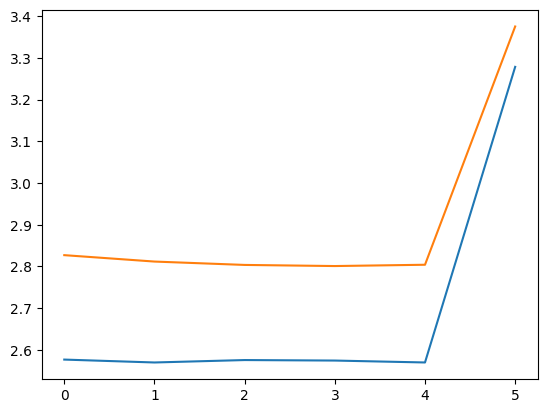

In [5]:
import matplotlib.pyplot as plt


def calculate_mae(model: LinearRegression, dataset: pd.DataFrame, 
                  target: str) -> float:
    predictors = model.feature_names_in_
    predictions = model.predict(dataset[predictors])

    return mean_absolute_error(dataset[target], predictions)

train_maes = [calculate_mae(model, train, target) for model in selection_models]
validation_maes = [calculate_mae(model, validation, target) \
                   for model in selection_models]

plt.plot(np.arange(len(selection_models)), train_maes, label='Train')
plt.plot(np.arange(len(selection_models)), validation_maes, label='Validation')
plt.show()

3. Plot mpg predictions against actual mpg values for the validation set using the best model.

The best model based on the training set had 5 predictors and achieved an MAE of 2.57
The best model based on the validation set had 3 predictors and achieved an MAE of 2.80


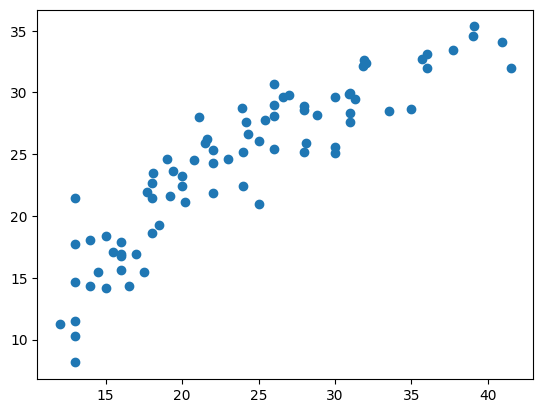

In [6]:
best_idx_train = np.argmin(train_maes)
print('The best model based on the training set had '
      f'{len(selection_models[best_idx_train].feature_names_in_)} '
      f'predictors and achieved an MAE of {train_maes[best_idx_train]:.2f}')

best_idx_validation = np.argmin(validation_maes)
print('The best model based on the validation set had '
      f'{len(selection_models[best_idx_validation].feature_names_in_)} '
      f'predictors and achieved an MAE of {validation_maes[best_idx_validation]:.2f}')

best_selection_model = selection_models[best_idx_validation]
best_predictions = best_selection_model.predict(
    validation[best_selection_model.feature_names_in_]
)

plt.scatter(validation[target], best_predictions)
plt.show()

4. Reflection: What is the best model based on training MAE? What about validation MAE? If they are different, reflect briefly on why. If not, could this happen? Why/why not?

_The best model based on the training set had five predictors. We would always expect the predictive performance in the training set to decrease as we add more predictors, and as such expect the model with all six to be best. However, as we are evaluating the MAE while optimising the models with the MSE, there is a theoretical chance that this is not the case, which explains what we see here. The best model based on the validation set had three predictors. As many predictors imply overfitting and few predictors imply underfitting, we expect the validation MAE to be shape as a U when plotted as a function of the number of predictors_

### 2. Regularization and automatic variable selection
In this assignment you will fit regularized LASSO models to investigate how the regularization parameter affects predictive performance and degree of overfitting.

1. Fit a range of LASSO models to predict mpg using all the predictors, with eleven lambdas uniformly spaced between 0 and 10 (e.g. 0, 1, 2, ..., 9, 10)
2. Plot the train and validation MAE as a function of the value of lambda

/home/esten/miniconda3/envs/ml/lib/python3.12/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/home/esten/miniconda3/envs/ml/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/esten/miniconda3/envs/ml/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.832e+03, tolerance: 1.954e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridg

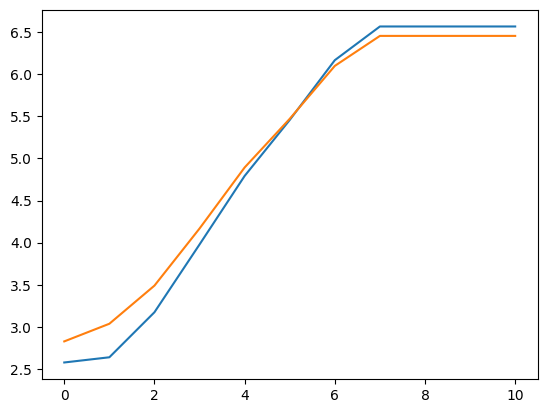

In [7]:
from sklearn.linear_model import Lasso


lambdas = np.arange(0, 11)
lasso_models = []
train_maes = []
validation_maes = []

for value in lambdas:
    model = Lasso(alpha=value)
    model.fit(train[predictors], train[target])
    lasso_models.append(model)
    
    train_maes.append(calculate_mae(model, train, target))
    validation_maes.append(calculate_mae(model, validation, target))

plt.plot(np.arange(len(lambdas)), train_maes)
plt.plot(np.arange(len(lambdas)), validation_maes)
plt.show()

3. Using the values plotted in b), print the lambda yielding the best model based on training MAE and validation MAE, and their corresponding MAE values.

In [8]:
best_idx_train = np.argmin(train_maes)
print('The best model based on the training set had a lambda of '
      f'{lambdas[best_idx_train]}, achieving an MAE of '
      f'{train_maes[best_idx_train]:.2f}')

best_idx_validation = np.argmin(validation_maes)
print('The best model based on the validation set had a lambda of '
      f'{lambdas[best_idx_validation]}, achieving an MAE of '
      f'{validation_maes[best_idx_validation]:.2f}')

best_lasso_model = lasso_models[best_idx_validation]

The best model based on the training set had a lambda of 0, achieving an MAE of 2.58
The best model based on the validation set had a lambda of 0, achieving an MAE of 2.83


4. Reflection: Is the best model based on training MAE and validation MAE using the same lambda? If not, why not? What would be the general pattern we expect to see here?

_The best model in both the training and validation set uses a lambda of 0 in this case. This is not guaranteed to happen. Generally, we expect the training MAE to improve as lambda decreases. Furthermore, as a low lambda generally yields overfitting and a high lambda generally yields underfitting, we expect the validation MAEs to have a U-shape_

5. Plot predictions against actual values and for the validation set using the best model

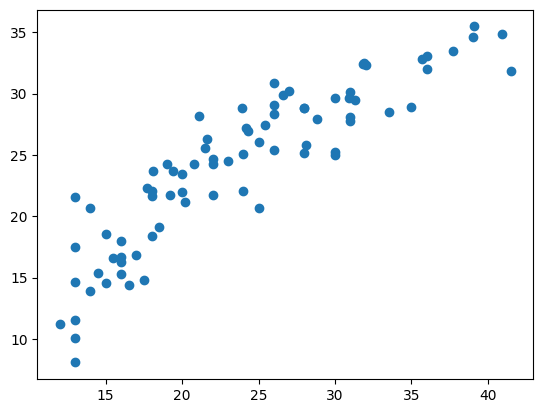

In [9]:
predictions = lasso_models[best_idx_validation].predict(
    validation[predictors]
)

plt.scatter(validation[target], predictions)
plt.show()

6. Reflection: Is the best LASSO model better or worse than the best model found using backward stepwise selection? Discuss briefly why this is/is not the case.

_The best LASSO model is slightly worse than the best model found using the backward stepwise selection in this case. However, as the best LASSO model uses a lambda of 0 this is just a regular linear regression model and not that interesting to discuss. More generally, it is worth noting that the backward selection model is not guaranteed to find an optimal solution as it uses a __local heuristic__ to make a series of decisions on what predictors to include. On the other hand, the LASSO gives us an __optimal set of predictors given our chosen lambda__, and we are not guaranteed to be using the correct lambda (no matter how cleverly we try to find it). So to summarize, none of these are silver bullets. Furthermore, it is worth noting that where the backward selection simply selects a set of predictors and fits a regular linear model, the LASSO model will also apply regularization to the predictors that remain (i.e. forcing them towards 0). Whether this is good or bad is an empirical question that depends on the data (although I would argue its generally a good idea)._

7. Print the names and coefficients of the predictors that are used by the LASSO model (e.g. not set to 0). How does this compare to the list you found using backwards stepwise selection?

In [10]:
lasso_predictors = [predictor for i, predictor in \
                    enumerate(best_lasso_model.feature_names_in_) \
                    if best_lasso_model.coef_[i] != 0]
print('Best predictors according to the LASSO models: '
      f'{lasso_predictors}')

selection_predictors = best_selection_model.feature_names_in_
print('Best predictors according to the backward selection: '
      f'{selection_predictors}')

Best predictors according to the LASSO models: ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year']
Best predictors according to the backward selection: ['weight' 'acceleration' 'year']


_Because the best LASSO model used a lambda of 0 it retains all predictors, and as such it is not that interesting to compare the two lists. However, if the chosen LASSO model applied some regularization (e.g. lambda > 0), I would expect the two lists to converge. However, it is worth noting that there is not theoretical guarantee this is bound to happen._